In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pickle
import sys, os

sys.path.append(os.path.join(os.path.abspath(""), "..", "src"))
from SegmentationAndLabeling import SegmentationAndLabeling
from SegLabel_DataClass import SegLabel
from qiskit_utils import linear_ramp_params, solutions_sampler, plot_solutions
from xy_mixer import xy_mixer_initial_state, xy_mixer

Warning! openQAOA is not installed!


In [2]:
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import (
    COBYLA,
)
from qiskit.utils import algorithm_globals
from qiskit_optimization.problems.quadratic_program import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp

from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

from qiskit import Aer
from qiskit.utils import QuantumInstance

## Model

In [3]:
with open("../data/hipster/005808361_class2_SegLabelData.pickle", "rb") as f:
    segLabel = pickle.load(f)

In [4]:
num_nodes = segLabel.num_detections
num_labels = segLabel.num_classes
num_segments = segLabel.max_num_persons

# alpha_dc
A = segLabel.alphas.copy()
A[A > 100] = 100
# print(A)

# beta_dc_d'c'
B = segLabel.betas.copy()
# B = np.nan_to_num(B, nan=0.0)
# print(B)

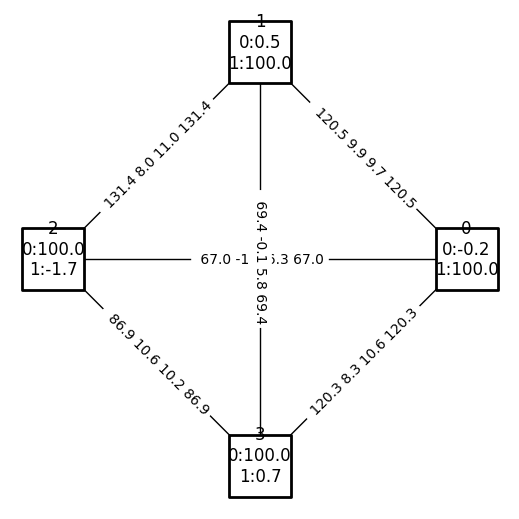

In [5]:
model = SegmentationAndLabeling(num_nodes, num_segments, num_labels, A, B)

model.draw_graph(draw_edge_labels=True, label_pos=0.5)

Model: Segmentation and Labeling
 - number of variables: 16
   - binary=16, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
objective: -2.200
status: OPTIMAL_SOLUTION(2)
  x_0_0_0=1
  x_1_0_1=1
  x_2_1_0=1
  x_3_1_1=1
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


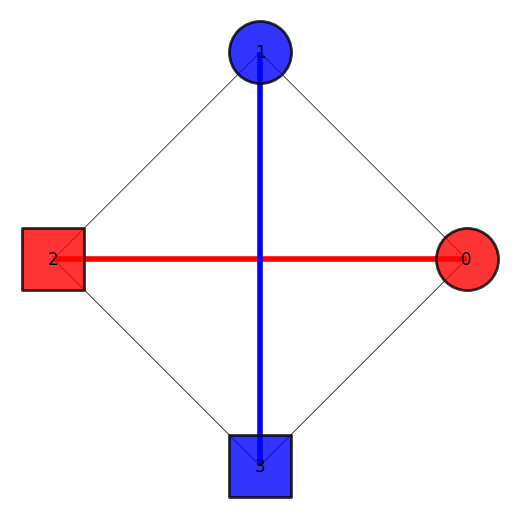

In [6]:
# Build the DOcplex model of the S&L problem
mdl = model.build_model()
mdl.solve()
mdl.print_information()
mdl.print_solution()

x = np.zeros(mdl.number_of_binary_variables)
for v in mdl.iter_binary_vars():
    x[v.index] = v.solution_value
# print(x)

obj_exact = mdl.objective_value
x_exact = x
print(x)

model.draw_solution(x)

In [7]:
node_map = dict((v, k) for k, v in segLabel.map_DNNdet_reindex.items())
label_map = dict((v, k) for k, v in segLabel.map_DNNclass_reindex.items())

print("==== Solutions ====")
for k, v in mdl.solution.as_name_dict().items():
    node, label, segment = [int(i) for i in k.split("_")[1:]]

    d = {}
    n = node_map[node]
    l = label_map[label]
    for person, v_p in segLabel.person_dic.items():
        if l in v_p:
            if n in v_p[l]:
                d[person] = v_p[l][n]
    print("\nDetection: {0}".format(n))
    print("  Class: {0}, \t Annotated: {1}".format(l, segLabel.dets_prob_dic[n]))
    print("  Person: {0}, \t Annotated: {1}".format(segment, d))

==== Solutions ====

Detection: 132
  Class: 3, 	 Annotated: {3: 0.5490145087242126, 13: 0.0}
  Person: 0, 	 Annotated: {0: 20.09975124224178, 1: 647.0927290582084}

Detection: 20
  Class: 3, 	 Annotated: {3: 0.3863688111305237, 13: 0.0}
  Person: 1, 	 Annotated: {0: 660.0272721638099, 1: 44.28317965096906}

Detection: 113
  Class: 13, 	 Annotated: {3: 0.0, 13: 0.8431219458580017}
  Person: 0, 	 Annotated: {0: 4.341724216253251, 1: 460.81253096270075}

Detection: 36
  Class: 13, 	 Annotated: {3: 0.0, 13: 0.3435472249984741}
  Person: 1, 	 Annotated: {0: 470.393208464121, 1: 28.312963325127225}


## QAOA

In [8]:
# Build the DOcplex model of the S&L problem
mdl = model.build_model(D=0.0)  #!!!! disable constraints
mdl.print_information()

Model: Segmentation and Labeling
 - number of variables: 16
   - binary=16, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP


In [9]:
mdl_qp = from_docplex_mp(mdl)
mdl_qubo = QuadraticProgramToQubo().convert(mdl_qp)
print(mdl_qubo.prettyprint())

qubitOp, offset = mdl_qubo.to_ising()

# Best QAOA results are always reached when renormalizing the Ising Hamiltonian weights into [-1, 1]
if True:
    w_max = np.max(np.abs(qubitOp.primitive.coeffs))
    qubitOp.primitive.coeffs /= w_max
    offset /= w_max

# print("Offset:", offset)
# print("Ising Hamiltonian:\n", str(qubitOp))

Problem name: Segmentation and Labeling

Minimize
  120.51*x_0_0_0*x_1_0_0 + 9.91*x_0_0_0*x_1_1_0 + 66.95*x_0_0_0*x_2_0_0
  - 1.32*x_0_0_0*x_2_1_0 + 120.31*x_0_0_0*x_3_0_0 + 8.31*x_0_0_0*x_3_1_0
  + 120.51*x_0_0_1*x_1_0_1 + 9.91*x_0_0_1*x_1_1_1 + 66.95*x_0_0_1*x_2_0_1
  - 1.32*x_0_0_1*x_2_1_1 + 120.31*x_0_0_1*x_3_0_1 + 8.31*x_0_0_1*x_3_1_1
  + 9.7*x_0_1_0*x_1_0_0 + 120.51*x_0_1_0*x_1_1_0 + 6.3*x_0_1_0*x_2_0_0
  + 66.95*x_0_1_0*x_2_1_0 + 10.61*x_0_1_0*x_3_0_0 + 120.31*x_0_1_0*x_3_1_0
  + 9.7*x_0_1_1*x_1_0_1 + 120.51*x_0_1_1*x_1_1_1 + 6.3*x_0_1_1*x_2_0_1
  + 66.95*x_0_1_1*x_2_1_1 + 10.61*x_0_1_1*x_3_0_1 + 120.31*x_0_1_1*x_3_1_1
  + 131.41*x_1_0_0*x_2_0_0 + 7.98*x_1_0_0*x_2_1_0 + 69.43*x_1_0_0*x_3_0_0
  - 0.11*x_1_0_0*x_3_1_0 + 131.41*x_1_0_1*x_2_0_1 + 7.98*x_1_0_1*x_2_1_1
  + 69.43*x_1_0_1*x_3_0_1 - 0.11*x_1_0_1*x_3_1_1 + 10.98*x_1_1_0*x_2_0_0
  + 131.41*x_1_1_0*x_2_1_0 + 5.79*x_1_1_0*x_3_0_0 + 69.43*x_1_1_0*x_3_1_0
  + 10.98*x_1_1_1*x_2_0_1 + 131.41*x_1_1_1*x_2_1_1 + 5.79*x_1_1_1*x_3_0_

## Initial state

In [10]:
initial_state = xy_mixer_initial_state(
    qubitOp.num_qubits, num_nodes, num_labels * num_segments
)
initial_state.draw(fold=150)

┌──────────┐                                     ┌─────────┐     
 q_0: ──┤ Ry(-π/4) ├───────────────────────────────────■─┤ Ry(π/4) ├──■──
      ┌─┴──────────┴─┐                 ┌─────────────┐ │ └─────────┘┌─┴─┐
 q_1: ┤ Ry(-0.95532) ├───────────────■─┤ Ry(0.95532) ├─■──────■─────┤ X ├
      └─┬──────────┬─┘   ┌─────────┐ │ └─────────────┘      ┌─┴─┐   └───┘
 q_2: ──┤ Ry(-π/3) ├───■─┤ Ry(π/3) ├─■────────■─────────────┤ X ├────────
        └──┬───┬───┘   │ └─────────┘        ┌─┴─┐           └───┘        
 q_3: ─────┤ X ├───────■────────────────────┤ X ├────────────────────────
        ┌──┴───┴───┐                        └───┘        ┌─────────┐     
 q_4: ──┤ Ry(-π/4) ├───────────────────────────────────■─┤ Ry(π/4) ├──■──
      ┌─┴──────────┴─┐                 ┌─────────────┐ │ └─────────┘┌─┴─┐
 q_5: ┤ Ry(-0.95532) ├───────────────■─┤ Ry(0.95532) ├─■──────■─────┤ X ├
      └─┬──────────┬─┘   ┌─────────┐ │ └─────────────┘      ┌─┴─┐   └───┘
 q_6: ──┤ Ry(-π/3) ├───■─┤ Ry(π/3) ├─■────────■─────────────┤ X ├────────
        └──┬───┬───┘   │ └─────────┘        ┌─┴─┐           └───┘        
 q_7: ─────┤ X ├───────■────────────────────┤ X ├────────────────────────
        ┌──┴───┴───┐                        └───┘        ┌─────────┐     
 q_8: ──┤ Ry(-π/4) ├───────────────────────────────────■─┤ Ry(π/4) ├──■──
      ┌─┴──────────┴─┐                 ┌─────────────┐ │ └─────────┘┌─┴─┐
 q_9: ┤ Ry(-0.95532) ├───────────────■─┤ Ry(0.95532) ├─■──────■─────┤ X ├
      └─┬──────────┬─┘   ┌─────────┐ │ └─────────────┘      ┌─┴─┐   └───┘
q_10: ──┤ Ry(-π/3) ├───■─┤ Ry(π/3) ├─■────────■─────────────┤ X ├────────
        └──┬───┬───┘   │ └─────────┘        ┌─┴─┐           └───┘        
q_11: ─────┤ X ├───────■────────────────────┤ X ├────────────────────────
        ┌──┴───┴───┐                        └───┘        ┌─────────┐     
q_12: ──┤ Ry(-π/4) ├───────────────────────────────────■─┤ Ry(π/4) ├──■──
      ┌─┴──────────┴─┐                 ┌─────────────┐ │ └─────────┘┌─┴─┐
q_13: ┤ Ry(-0.95532) ├───────────────■─┤ Ry(0.95532) ├─■──────■─────┤ X ├
      └─┬──────────┬─┘   ┌─────────┐ │ └─────────────┘      ┌─┴─┐   └───┘
q_14: ──┤ Ry(-π/3) ├───■─┤ Ry(π/3) ├─■────────■─────────────┤ X ├────────
        └──┬───┬───┘   │ └─────────┘        ┌─┴─┐           └───┘        
q_15: ─────┤ X ├───────■────────────────────┤ X ├────────────────────────
           └───┘                            └───┘

## Mixer

In [11]:
mixer = xy_mixer(qubitOp.num_qubits, num_nodes, num_labels * num_segments)
mixer.draw()

┌───────┐          ┌───────┐               ┌───────┐              »
 q_0: ──■──┤ Rx(β) ├──■────■──┤ Rx(β) ├──■────■───────┤ Rx(β) ├───────────■──»
      ┌─┴─┐└───┬───┘┌─┴─┐  │  └───┬───┘  │    │       └───┬───┘┌───────┐  │  »
 q_1: ┤ X ├────■────┤ X ├──┼──────┼──────┼────┼────■──────┼────┤ Rx(β) ├──┼──»
      └───┘         └───┘┌─┴─┐    │    ┌─┴─┐  │  ┌─┴─┐    │    └───┬───┘  │  »
 q_2: ───────────────────┤ X ├────■────┤ X ├──┼──┤ X ├────┼────────■──────┼──»
                         └───┘         └───┘┌─┴─┐└───┘    │             ┌─┴─┐»
 q_3: ──────────────────────────────────────┤ X ├─────────■─────────────┤ X ├»
           ┌───────┐          ┌───────┐     └───┘     ┌───────┐         └───┘»
 q_4: ──■──┤ Rx(β) ├──■────■──┤ Rx(β) ├──■────■───────┤ Rx(β) ├───────────■──»
      ┌─┴─┐└───┬───┘┌─┴─┐  │  └───┬───┘  │    │       └───┬───┘┌───────┐  │  »
 q_5: ┤ X ├────■────┤ X ├──┼──────┼──────┼────┼────■──────┼────┤ Rx(β) ├──┼──»
      └───┘         └───┘┌─┴─┐    │    ┌─┴─┐  │  ┌─┴─┐    │    └───┬───┘  │  »
 q_6: ───────────────────┤ X ├────■────┤ X ├──┼──┤ X ├────┼────────■──────┼──»
                         └───┘         └───┘┌─┴─┐└───┘    │             ┌─┴─┐»
 q_7: ──────────────────────────────────────┤ X ├─────────■─────────────┤ X ├»
           ┌───────┐          ┌───────┐     └───┘     ┌───────┐         └───┘»
 q_8: ──■──┤ Rx(β) ├──■────■──┤ Rx(β) ├──■────■───────┤ Rx(β) ├───────────■──»
      ┌─┴─┐└───┬───┘┌─┴─┐  │  └───┬───┘  │    │       └───┬───┘┌───────┐  │  »
 q_9: ┤ X ├────■────┤ X ├──┼──────┼──────┼────┼────■──────┼────┤ Rx(β) ├──┼──»
      └───┘         └───┘┌─┴─┐    │    ┌─┴─┐  │  ┌─┴─┐    │    └───┬───┘  │  »
q_10: ───────────────────┤ X ├────■────┤ X ├──┼──┤ X ├────┼────────■──────┼──»
                         └───┘         └───┘┌─┴─┐└───┘    │             ┌─┴─┐»
q_11: ──────────────────────────────────────┤ X ├─────────■─────────────┤ X ├»
           ┌───────┐          ┌───────┐     └───┘     ┌───────┐         └───┘»
q_12: ──■──┤ Rx(β) ├──■────■──┤ Rx(β) ├──■────■───────┤ Rx(β) ├───────────■──»
      ┌─┴─┐└───┬───┘┌─┴─┐  │  └───┬───┘  │    │       └───┬───┘┌───────┐  │  »
q_13: ┤ X ├────■────┤ X ├──┼──────┼──────┼────┼────■──────┼────┤ Rx(β) ├──┼──»
      └───┘         └───┘┌─┴─┐    │    ┌─┴─┐  │  ┌─┴─┐    │    └───┬───┘  │  »
q_14: ───────────────────┤ X ├────■────┤ X ├──┼──┤ X ├────┼────────■──────┼──»
                         └───┘         └───┘┌─┴─┐└───┘    │             ┌─┴─┐»
q_15: ──────────────────────────────────────┤ X ├─────────■─────────────┤ X ├»
                                            └───┘                       └───┘»
«                                                 
« q_0: ───────────────────────────────────────────
«                ┌───────┐                        
« q_1: ──■────■──┤ Rx(β) ├──■─────────────────────
«      ┌─┴─┐  │  └───┬───┘  │       ┌───────┐     
« q_2: ┤ X ├──┼──────┼──────┼────■──┤ Rx(β) ├──■──
«      └───┘┌─┴─┐    │    ┌─┴─┐┌─┴─┐└───┬───┘┌─┴─┐
« q_3: ─────┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├
«           └───┘         └───┘└───┘         └───┘
« q_4: ───────────────────────────────────────────
«                ┌───────┐                        
« q_5: ──■────■──┤ Rx(β) ├──■─────────────────────
«      ┌─┴─┐  │  └───┬───┘  │       ┌───────┐     
« q_6: ┤ X ├──┼──────┼──────┼────■──┤ Rx(β) ├──■──
«      └───┘┌─┴─┐    │    ┌─┴─┐┌─┴─┐└───┬───┘┌─┴─┐
« q_7: ─────┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├
«           └───┘         └───┘└───┘         └───┘
« q_8: ───────────────────────────────────────────
«                ┌───────┐                        
« q_9: ──■────■──┤ Rx(β) ├──■─────────────────────
«      ┌─┴─┐  │  └───┬───┘  │       ┌───────┐     
«q_10: ┤ X ├──┼──────┼──────┼────■──┤ Rx(β) ├──■──
«      └───┘┌─┴─┐    │    ┌─┴─┐┌─┴─┐└───┬───┘┌─┴─┐
«q_11: ─────┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├
«           └───┘         └───┘└───┘         └───┘
«q_12: ───────────────────────────────────────────
«                ┌───────┐                        
«q_13: ──■────■──┤ Rx(β) ├─

## QAOA ansatz

In [12]:
p = 1

ansatz = QAOAAnsatz(
    qubitOp, reps=p, initial_state=initial_state, mixer_operator=mixer
).decompose()

# ansatz.draw()

In [13]:
n_shots = 128
seed = 12345

algorithm_globals.random_seed = seed
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed, shots=n_shots
)

opt = COBYLA(maxiter=1000, tol=1e-4)

evals = []
values = []
params = []


def store_intermediate_result(step, parameters, mean, std):
    evals.append(step)
    values.append(mean)
    params.append(parameters)
    return


vqe = VQE(
    ansatz=ansatz,
    optimizer=opt,
    quantum_instance=quantum_instance,
    callback=store_intermediate_result,
    initial_point=linear_ramp_params(p, beta_sign=-1.0),
)

results = vqe.compute_minimum_eigenvalue(qubitOp)

In [14]:
print("Optimal QAOA circuit parameters (β, γ):\n")
print(list(results.optimal_parameters.values()))

Optimal QAOA circuit parameters (β, γ):

[-0.6085530001163246, 1.3607545287324776]


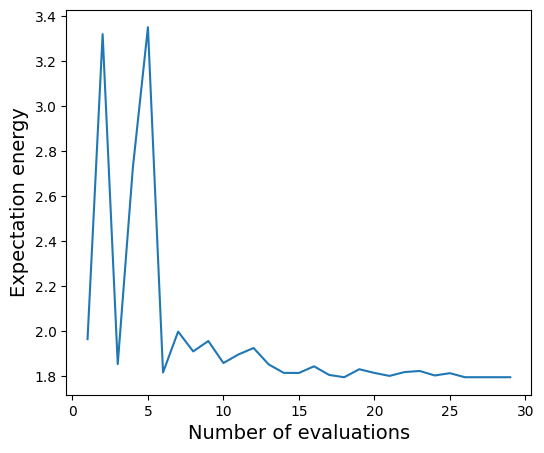

In [15]:
# Expectation energy of the Ising Hamiltonian (possibly normalized)
plt.rcParams["figure.figsize"] = (6, 5)
plt.plot(evals, np.array(values) + offset)
plt.xlabel("Number of evaluations", fontsize=14)
plt.ylabel("Expectation energy", fontsize=14)
plt.show()

In [16]:
# Resample the optimized QAOA anasatz with higher number of shots
sols = solutions_sampler(
    mdl_qubo.objective.evaluate,
    vqe.ansatz,
    list(results.optimal_parameters.values()),
    backend=backend,
    n_shots=512,
    seed=12345,
)

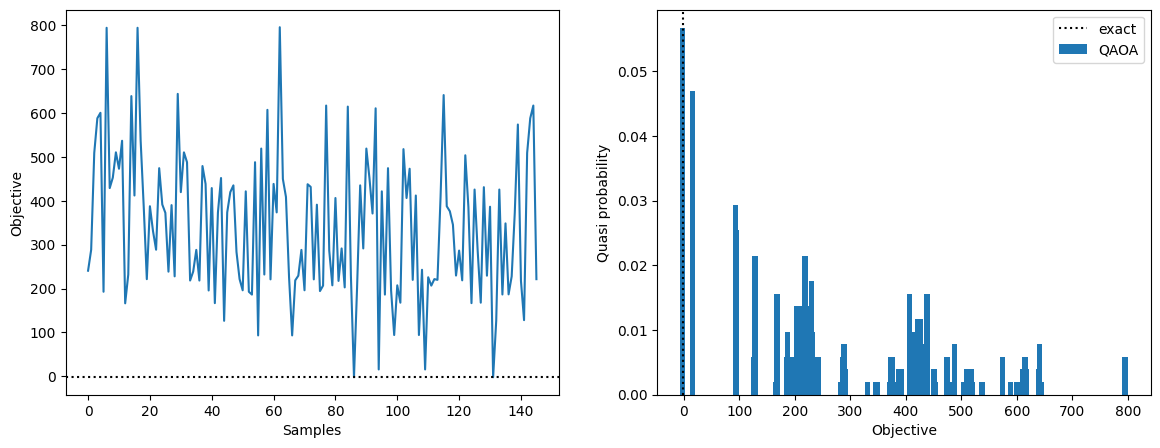

In [17]:
plot_solutions({"QAOA": sols}, obj_exact, width=10)

In [18]:
most_likely_sols = sorted(sols, key=lambda k: k["prob"])[::-1]
for s in most_likely_sols[:4]:
    print(s)

{'x': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), 'obj': -2.2, 'prob': 0.056640625}
{'x': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), 'obj': 15.52, 'prob': 0.046875}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), 'obj': -2.2, 'prob': 0.033203125}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), 'obj': 15.52, 'prob': 0.029296875}


In [19]:
lowest_obj_sols = sorted(sols, key=lambda k: k["obj"])
for s in lowest_obj_sols[:8]:
    print(s)

{'x': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), 'obj': -2.2, 'prob': 0.056640625}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), 'obj': -2.2, 'prob': 0.033203125}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), 'obj': 15.52, 'prob': 0.029296875}
{'x': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]), 'obj': 15.52, 'prob': 0.046875}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]), 'obj': 93.13000000000001, 'prob': 0.01171875}
{'x': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]), 'obj': 93.13000000000001, 'prob': 0.029296875}
{'x': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]), 'obj': 94.01, 'prob': 0.009765625}
{'x': array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]), 'obj': 94.01, 'prob': 0.025390625}


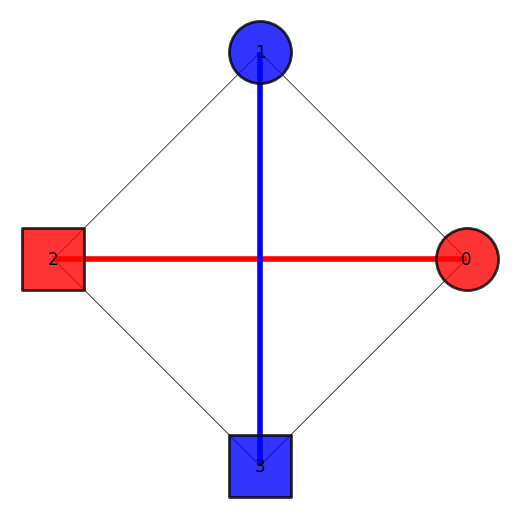

In [20]:
model.draw_solution(lowest_obj_sols[0]["x"])

## Surface plot

In [21]:
N1 = 20
N2 = 20
betas = np.linspace(start=-np.pi, stop=np.pi, num=N1)
gammas = np.linspace(start=-np.pi, stop=np.pi, num=N2)

vqe = VQE(
    ansatz=ansatz,
    optimizer=opt,
    quantum_instance=quantum_instance,
)
vqe.optimizer._options["maxiter"] = 0

energy = np.zeros((N1, N2))
for i, b in enumerate(betas):
    for j, g in enumerate(gammas):
        vqe.initial_point = [b, g]
        out = vqe.compute_minimum_eigenvalue(qubitOp)
        energy[i, j] = out.eigenvalue.real + offset

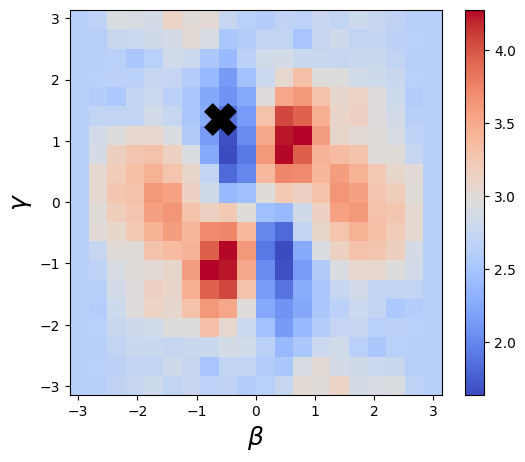

In [22]:
opt_angles = list(results.optimal_parameters.values())

fig, ax = plt.subplots()
im = ax.imshow(
    energy.T,
    interpolation=None,
    origin="lower",
    extent=[betas.min(), betas.max(), gammas.min(), gammas.max()],
    vmax=None,
    aspect="auto",
    cmap="coolwarm",
)
fig.colorbar(im)

ax.scatter(opt_angles[0], opt_angles[1], marker="X", s=500, c="black")

ax.set_xlabel(r"$\beta$", fontsize=18)
ax.set_ylabel(r"$\gamma$", fontsize=18)
plt.show()